### Setup

In [10]:
# !pip install kaggle --upgrade
# !pip install catboost
# !pip install shap

In [26]:
from tools.setup import *

In [13]:
wkdir = '/home/jovyan/work/analysis/DATASCI-WiDS'

### Read data

In [14]:
training =  pd.read_csv(wkdir + "/data/TrainingWiDS2021.csv")
data_dictionary = pd.read_csv(wkdir + "/data/DataDictionaryWiDS2021.csv")
training = training.drop(columns=['Unnamed: 0'])

unlabeled = pd.read_csv(wkdir + "/data/UnlabeledWiDS2021.csv")
unlabeled = unlabeled.drop(columns=['Unnamed: 0'])

### Data cleaning

In [15]:
data_types = dabl.detect_types(training)

In [16]:
data_types

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
encounter_id,True,False,False,False,False,False,False
hospital_id,False,False,True,False,False,False,False
age,True,False,False,False,False,False,False
bmi,True,False,False,False,False,False,False
elective_surgery,False,False,False,True,False,False,False
ethnicity,False,False,False,True,False,False,False
gender,False,False,False,True,False,False,False
height,True,False,False,False,False,False,False
hospital_admit_source,False,False,False,True,False,False,False
icu_admit_source,False,False,False,True,False,False,False


In [23]:
categoricals = data_types[data_types['categorical']==True].index.tolist()
print("**categorical features**")
print(categoricals)

**categorical features**
['elective_surgery', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_type', 'apache_post_operative', 'intubated_apache', 'ventilated_apache', 'diabetes_mellitus']


In [24]:
continuous = data_types[data_types['continuous']==True].index.tolist()
print("**first 10 continuous features**")
print(continuous[:10])
print("**total continuous features**")
print(len(continuous))

**first 10 continuous features**
['encounter_id', 'age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'bilirubin_apache']
**total continuous features**
157


In [35]:
useless = data_types[data_types['useless']==True].index.tolist()
print("**useless features**")
print(useless)
print("**total useless features**")
print(len(useless))

**useless features**
['icu_stay_type', 'readmission_status', 'arf_apache', 'gcs_unable_apache', 'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
**total useless features**
11


### Train-test-validate split of labelled data for parameters tunning

**define target** 

In [36]:
target = 'diabetes_mellitus'

**split data: train-validate-test**

In [37]:
# first split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
for train_index, test_index in split.split(training, training[target]):
    strat_train_set = training.loc[train_index]
    strat_test_set = training.loc[test_index]
training['test'] = np.where(training['encounter_id'].isin(strat_test_set['encounter_id']), True, False)
non_test = training.loc[training['test'] == False]
test = training.loc[training['test'] == True]

# second split
train, validate = train_test_split(non_test, test_size=0.2, stratify=non_test[target], random_state=random_state)

In [38]:
print('train : ' + str(train.shape))
print('test : ' + str(test.shape))
print('validate : ' + str(validate.shape))

train : (83300, 181)
test : (26032, 181)
validate : (20825, 181)


**handle missing values by the split above**

In [39]:
%%time

## fill NA of numerics with median value
for col in continuous:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)
    validate[col].fillna(validate.median(), inplace=True)  

CPU times: user 16.8 s, sys: 51 ms, total: 16.9 s
Wall time: 16.9 s


In [40]:
## fill NAs of categoricals with most common values
categorical_nas = ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source']
train[categorical_nas] = train[categorical_nas].fillna(train.mode().iloc[0])
test[categorical_nas] = test[categorical_nas].fillna(test.mode().iloc[0])
validate[categorical_nas] = validate[categorical_nas].fillna(validate.mode().iloc[0])

In [41]:
print('unique values')
for col in categoricals:
    print(col + ' : ' + str(train[col].unique()))

unique values
elective_surgery : [0 1]
ethnicity : ['Caucasian' 'African American' 'Other/Unknown' 'Asian' 'Hispanic'
 'Native American']
gender : ['M' 'F']
hospital_admit_source : ['Floor' 'Emergency Department' 'Step-Down Unit (SDU)' 'Direct Admit'
 'Operating Room' 'Recovery Room' 'Other Hospital' 'Acute Care/Floor'
 'PACU' 'Chest Pain Center' 'Other ICU' 'Other' 'ICU to SDU' 'ICU'
 'Observation']
icu_admit_source : ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU']
icu_type : ['CSICU' 'CCU-CTICU' 'CTICU' 'SICU' 'Med-Surg ICU' 'MICU' 'Cardiac ICU'
 'Neuro ICU']
apache_post_operative : [0 1]
intubated_apache : [1 0]
ventilated_apache : [1 0]
diabetes_mellitus : [0 1]


### Features

In [45]:
categoricals.remove(target)
categoricals

['elective_surgery',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_type',
 'apache_post_operative',
 'intubated_apache',
 'ventilated_apache']

In [47]:
continuous.remove('encounter_id')

In [48]:
model_features = continuous + categoricals

## Model

In [49]:
X_train = train[model_features]
y_train = train[target]
X_test = test[model_features]
y_test = test[target]
X_validate = validate[model_features]
y_validate = validate[target]
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)

(83300, 165)
(26032, 165)
(20825, 165)


### Hyperparameter tuning

#### Random search

In [50]:
grid = {'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3],
        'depth': [4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [3, 4, 5],
        'iterations': [400, 500, 600, 700],
        'early_stopping_rounds' : [30, 40, 50, 60],
        'custom_metric':['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'BalancedAccuracy']}

In [51]:
%%time

model = CatBoostClassifier()

pool_ds = pd.concat([X_train, X_test])
label_ds = pd.concat([y_train, y_test])
rs_pool = Pool(data = pool_ds,
              label = label_ds,
              cat_features = categoricals)

model.randomized_search(grid,
                      rs_pool,
                      y=None,
                      cv=3,
                      n_iter=10,
                      partition_random_seed=0,
                      calc_cv_statistics=True, 
                      search_by_train_test_split=True,
                      refit=True, #refit best model ?
                      shuffle=True, 
                      stratified=True, 
                      train_size=0.8, 
                      verbose=True)


bestTest = 0.3859299597
bestIteration = 599

0:	loss: 0.3859300	best: 0.3859300 (0)	total: 16.5s	remaining: 2m 28s

bestTest = 0.367638276
bestIteration = 691

1:	loss: 0.3676383	best: 0.3676383 (1)	total: 36.1s	remaining: 2m 24s

bestTest = 0.3710188851
bestIteration = 399

2:	loss: 0.3710189	best: 0.3676383 (1)	total: 49.9s	remaining: 1m 56s

bestTest = 0.3658209544
bestIteration = 699

3:	loss: 0.3658210	best: 0.3658210 (3)	total: 1m 13s	remaining: 1m 50s

bestTest = 0.3649417267
bestIteration = 699

4:	loss: 0.3649417	best: 0.3649417 (4)	total: 1m 42s	remaining: 1m 42s

bestTest = 0.3760051183
bestIteration = 699

5:	loss: 0.3760051	best: 0.3649417 (4)	total: 2m 20s	remaining: 1m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.372539618
bestIteration = 63

6:	loss: 0.3725396	best: 0.3649417 (4)	total: 2m 28s	remaining: 1m 3s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.3649717464
bestIteration = 365

Metric AUC is not calculated on tr

{'params': {'depth': 6,
  'od_wait': 50,
  'l2_leaf_reg': 4,
  'iterations': 700,
  'learning_rate': 0.05,
  'custom_metric': 'BalancedAccuracy'},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,

In [52]:
# get best parms
rs_best_params = model.get_params()
rs_best_params

{'depth': 6,
 'od_wait': 50,
 'l2_leaf_reg': 4,
 'iterations': 700,
 'learning_rate': 0.05,
 'custom_metric': 'BalancedAccuracy'}

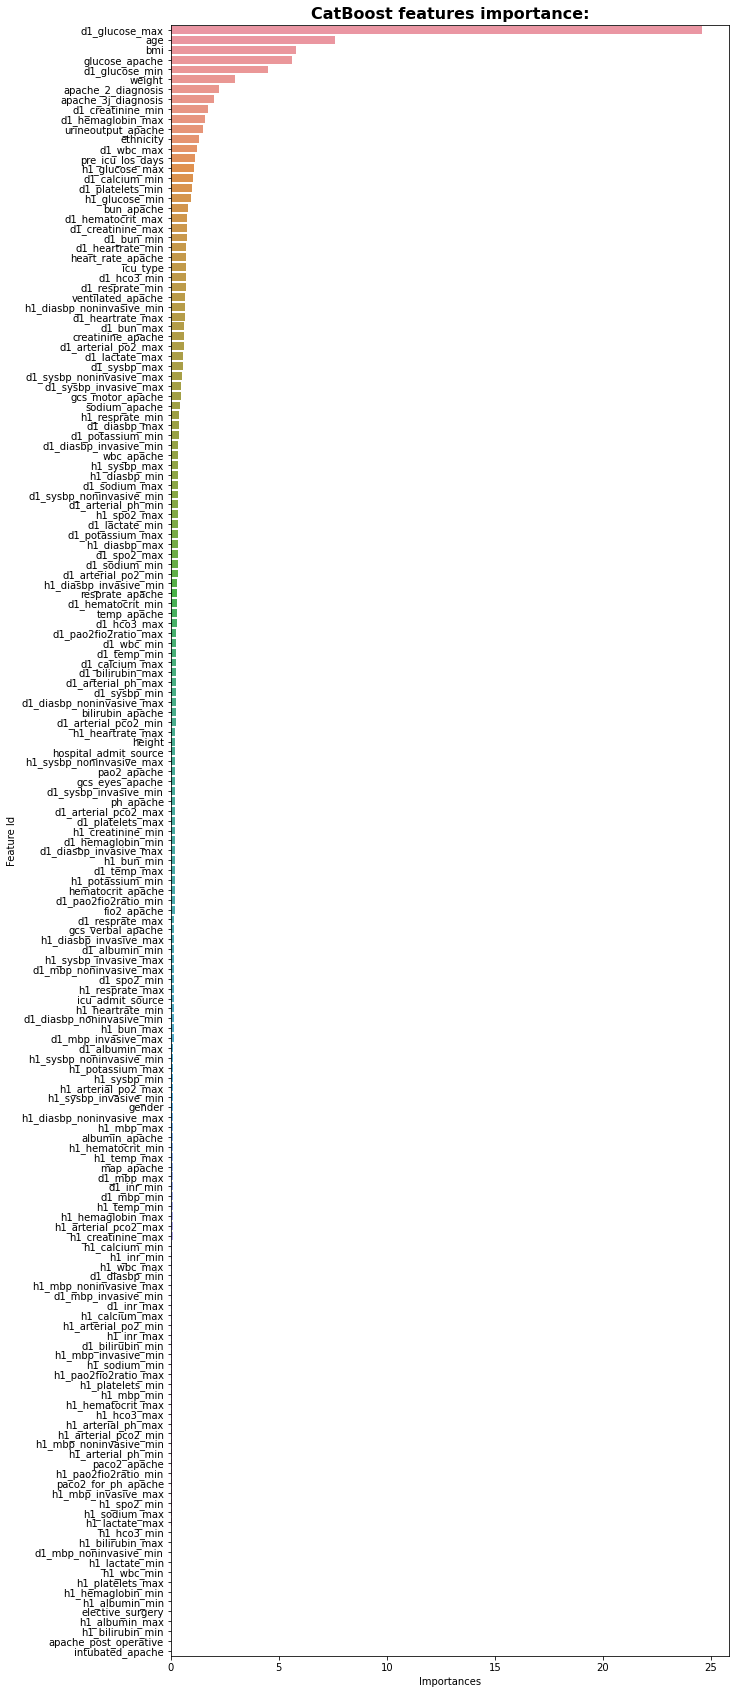

In [54]:
def plot_feat_imp(model):
    feature_importance_df = pd.DataFrame(model.get_feature_importance(prettified=True))
    plt.figure(figsize=(10, 30));
    sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
    plt.title('CatBoost features importance:', fontsize=16, weight="bold");

plot_feat_imp(model)

### Check model's performance on unseen data

https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

<Figure size 720x720 with 0 Axes>

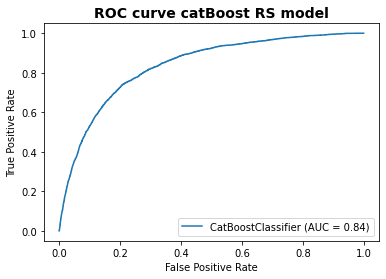

In [56]:
plt.figure(figsize=(10, 10))
metrics.plot_roc_curve(model, X_validate, y_validate)
plt.title('ROC curve catBoost RS model', fontsize=14, weight="bold")
plt.show()

In [58]:
y_pred = pd.DataFrame(model.predict(X_validate[model_features]))
y_true = y_validate
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     16321
           1       0.74      0.52      0.61      4504

    accuracy                           0.86     20825
   macro avg       0.81      0.74      0.76     20825
weighted avg       0.85      0.86      0.85     20825



### Retrain on all data

In [ ]:
# {'depth': 6,
#  'od_wait': 50,
#  'l2_leaf_reg': 4,
#  'iterations': 700,
#  'learning_rate': 0.05,
#  'custom_metric': 'BalancedAccuracy'}

In [57]:
%%time

## retrain on all data
pool_ds = pd.concat([X_train, X_test, X_validate])
label_ds = pd.concat([y_train, y_test, y_validate])

model = CatBoostClassifier(**rs_best_params)

model.fit(pool_ds,
          label_ds,
          cat_features = categoricals,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6628023	total: 59.6ms	remaining: 41.7s
1:	learn: 0.6345507	total: 119ms	remaining: 41.5s
2:	learn: 0.6097831	total: 177ms	remaining: 41.2s
3:	learn: 0.5897418	total: 237ms	remaining: 41.2s
4:	learn: 0.5690884	total: 294ms	remaining: 40.9s
5:	learn: 0.5515689	total: 347ms	remaining: 40.2s
6:	learn: 0.5357062	total: 404ms	remaining: 40s
7:	learn: 0.5224471	total: 455ms	remaining: 39.4s
8:	learn: 0.5114900	total: 513ms	remaining: 39.4s
9:	learn: 0.5014294	total: 571ms	remaining: 39.4s
10:	learn: 0.4919291	total: 630ms	remaining: 39.4s
11:	learn: 0.4837358	total: 683ms	remaining: 39.1s
12:	learn: 0.4766899	total: 738ms	remaining: 39s
13:	learn: 0.4701603	total: 797ms	remaining: 39.1s
14:	learn: 0.4646899	total: 853ms	remaining: 39s
15:	learn: 0.4592441	total: 914ms	remaining: 39.1s
16:	learn: 0.4547120	total: 970ms	remaining: 39s
17:	learn: 0.4500759	total: 1.03s	remaining: 39.1s
18:	learn: 0.4459792	total: 1.09s	remaining: 39s
19:	learn: 0.4418363	total: 1.15s	remaining: 38.9s

### Predict on unlabelled data

In [59]:
## fill NA of numerics with median value
for col in continuous:
    unlabeled.fillna(unlabeled.median(), inplace=True)
## fill NA of categoricals with mode    
for col in categoricals:
    unlabeled.fillna(unlabeled.mode().iloc[0], inplace=True)

In [60]:
unlabeled

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,144740,10141,72,27.60,0,Caucasian,F,152.40,Floor,Accident & Emergency,82,admit,Med-Surg ICU,0.02,0,80.00,2.80,110.00,104.01,0,0,1.90,44.00,1.49,0.50,4.00,6.00,0.00,5.00,97.00,38.00,39.90,0,54.00,39.60,39.60,104.00,7.37,31.00,130.00,36.40,"1,569.50",0,5.40,76.00,47.00,104.00,40.00,104.00,40.00,66.00,38.00,101.00,62.00,123.00,54.00,123.00,54.00,35.00,15.00,100.00,96.00,150.00,92.00,149.00,76.00,149.00,76.00,38.70,35.60,67.00,56.00,59.00,59.00,59.00,59.00,46.00,44.00,90.00,75.00,80.00,80.00,80.00,80.00,19.00,19.00,97.00,96.00,135.00,114.00,116.00,116.00,116.00,116.00,36.40,36.40,2.80,2.80,1.90,1.90,44.00,40.00,9.80,9.30,1.49,1.44,104.00,97.00,26.00,23.00,14.50,14.20,42.80,39.90,1.30,1.20,1.90,1.50,173.00,173.00,5.70,4.90,132.00,130.00,5.60,5.40,2.80,2.80,1.90,1.90,40.00,40.00,9.80,9.80,1.49,1.49,104.00,104.00,26.00,26.00,14.50,14.50,42.80,42.80,1.30,1.20,2.00,1.90,173.00,173.00,4.90,4.90,132.00,132.00,5.60,5.60,42.00,36.50,7.40,7.34,133.00,85.00,288.00,205.45,41.00,39.80,7.36,7.35,132.00,118.00,234.00,224.00,0,0,0,0,0,0,0
1,141990,10141,86,27.60,0,Caucasian,F,175.30,Emergency Department,Accident & Emergency,

In [80]:
# unlabeled['icu_admit_source'].replace({'65.0':unlabeled['icu_admit_source'].mode().iloc[0]}, inplace=True)
# unlabeled['hospital_admit_source'].replace({'65.0':unlabeled['hospital_admit_source'].mode().iloc[0]}, inplace=True)

In [61]:
predicted_probs = pd.DataFrame(model.predict_proba(unlabeled[model_features])[:, 1])
predicted_labels = pd.DataFrame(model.predict(unlabeled[model_features]))

In [62]:
result = unlabeled['encounter_id'].to_frame()
result[target] = predicted_probs

In [63]:
result = result.reset_index(drop=True)

In [64]:
result

,encounter_id,diabetes_mellitus
0,144740,0.05
1,141990,0.11
2,142038,0.15
3,138628,0.07
4,141682,0.27
...,...,...
10229,143750,0.06
10230,143813,0.08
10231,137126,0.07
10232,135652,0.02


In [65]:
result.to_csv('/home/jovyan/work/analysis/DATASCI-WiDS/submissions/submission_catboost_RS_180221.csv', index=False)

### Submit to kaggle

In [69]:
import kaggle

In [70]:
!kaggle competitions submit -c widsdatathon2021 -f '/home/jovyan/work/analysis/DATASCI-WiDS/submissions/submission_catboost_RS_180221.csv' -m "catboost RS submission 180221"

100%|████████████████████████████████████████| 269k/269k [00:03<00:00, 78.8kB/s]
Successfully submitted to WiDS Datathon 2021

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="code"></form>''')